In [1]:
import sys
sys.path.append("../..")

# Noisy Pendulum - Curbature Kalman Filter Example

Estimate pendulum state with CKF and CRTS as in Examples 6.2 and 10.2 of the book Bayesian Filtering and Smoothing


## Imports

### Standard imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
from scipy import linalg, stats
import tqdm

### Helpers imports

In [3]:
from python.common_utilities import generate_pendulum, RandomState, rmse, plot_pendulum

## Routine

Set the parameters:

In [4]:
dt = 0.01
g  = 9.81

In [5]:
Q  = 0.01 * np.array([[dt ** 3 / 3, dt ** 2 / 2], 
                       [dt ** 2 / 2, dt]])
R  = 0.1

In [6]:
x_0 = np.array([1.5, 0.])

## Simulate data

In [7]:
random_state = RandomState(1)
steps = 500

timeline, states, observations = generate_pendulum(x_0, g, Q, dt, R, steps, random_state)

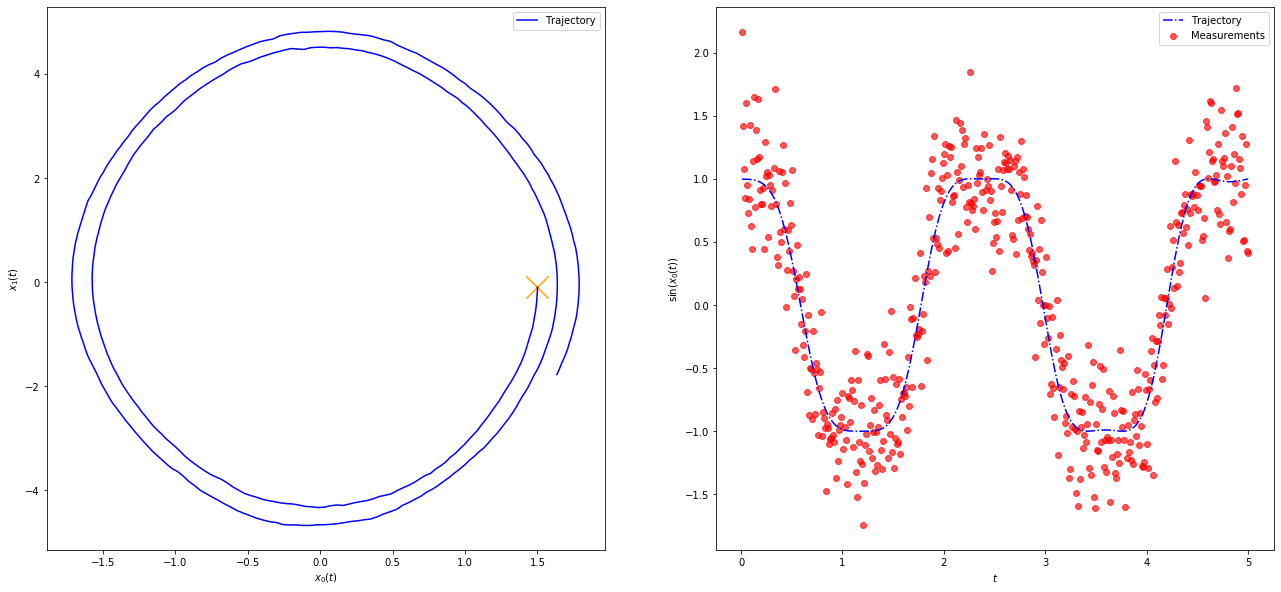

In [8]:
plot_pendulum(timeline, observations, states, "Trajectory")

## Curbature Kalman Filter

In [9]:
m_0 = np.array([1.6, 0.])  # Slightly off
P_0 = np.array([[0.1, 0.], 
                [0., 0.1]])

In [10]:
# method parameters
from itertools import product
from numpy.polynomial.hermite_e import hermegauss

n = m_0.shape[0]

sample_points = np.concatenate([np.eye(n), -np.eye(n)]).T * np.sqrt(n)
weights = np.full(2 * n, 0.5 / n)


In [11]:
def curbature_kalman_filter(m_0, P_0, g, Q, dt, R, observations, sample_points, weights):
    M = m_0.shape[-1]
    steps = observations.shape[0]
    
    ghkf_m = np.empty((steps, M))
    ghkf_P = np.empty((steps, M, M))
    
    m = m_0[:]
    P = P_0[:]
    
    zeros = np.zeros((n, 1))
    
    for i in range(steps):
        observation = observations[i]
        
        # Compute the Sigma-Points for the dynamics
        L = np.linalg.cholesky(P)
        sigma_points = L @ sample_points + m.reshape(-1, 1)
        
        # Progagate through the dynamics
        sigma_points[0, :], sigma_points[1, :] = sigma_points[0, :] + dt * sigma_points[1, :], sigma_points[1, :] - g * dt * np.sin(sigma_points[0, :])        
        
        # Predicted state distribution
        m = np.dot(sigma_points, weights)
        P = np.dot(weights.reshape(1, -1) * (sigma_points - m.reshape(-1, 1)), (sigma_points - m.reshape(-1, 1)).T) + Q

        # Compute the Sigma-Points for the observation
        L = np.linalg.cholesky(P)
        sigma_points = L @ sample_points + m.reshape(-1, 1)
        
        # Progagate through the measurement model
        sigma_observations = np.sin(sigma_points[0, :])
        
        # sigma points measurement mean and covariance
        predicted_mu = np.dot(sigma_observations, weights)
        predicted_cov = np.dot(weights * (sigma_observations - predicted_mu), sigma_observations - predicted_mu) + R
        cross_cov = np.dot(sigma_points - m.reshape(-1, 1), weights * (sigma_observations - predicted_mu))
        
        # Gain
        K = cross_cov / predicted_cov # Works only when predicted_cov is scalar
        m = m + K * (observation - predicted_mu)
        P = P - predicted_cov * K.reshape(-1, 1) * K
        
        ghkf_m[i] = m
        ghkf_P[i] = P
    return ghkf_m, ghkf_P

In [12]:
ckf_m, ckf_P = curbature_kalman_filter(m_0, P_0, g, Q, dt, R, observations, sample_points, weights)

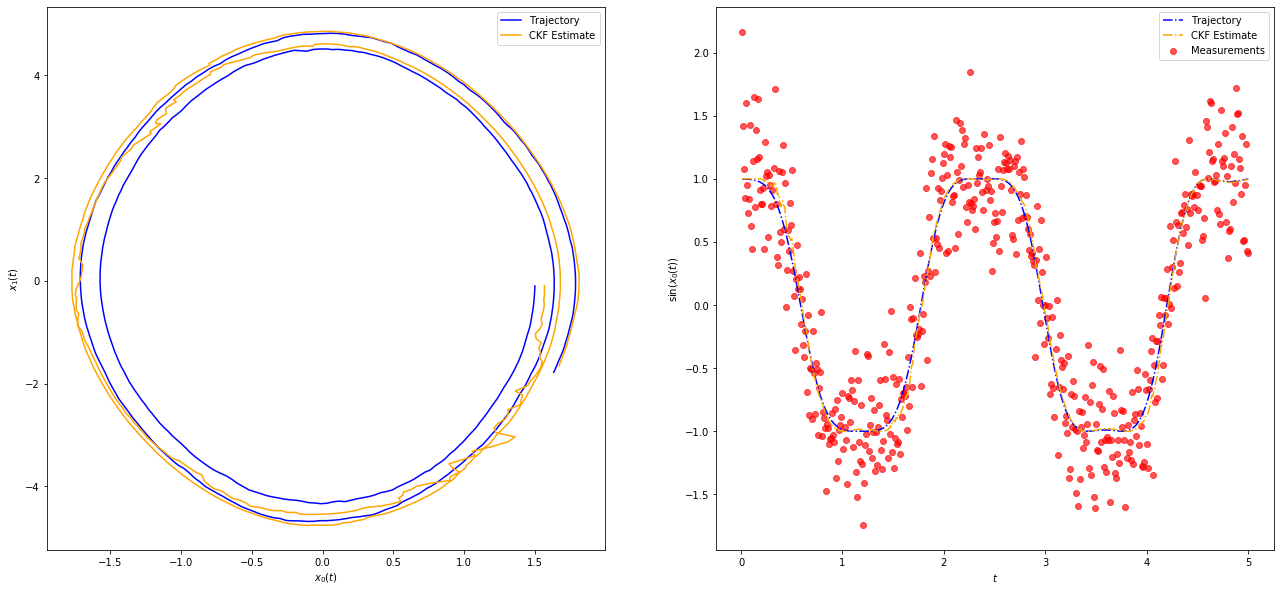

In [13]:
plot_pendulum(timeline, observations, states, "Trajectory", ckf_m, "CKF Estimate")

In [14]:
rmse_ckf = rmse(ckf_m[:, :1], states[:, :1])
print(f"CKF RMSE: {rmse_ckf}")

CKF RMSE: 0.09591465524348737


## Curbature RTS

In [15]:
def curbature_smoother(ghkf_m, ghkf_P, g, Q, dt, R, sample_points, weights):
    
    steps, M = ghkf_m.shape
    
    rts_m = np.empty((steps, M))
    rts_P = np.empty((steps, M, M))
    
    m = ghkf_m[-1]
    P = ghkf_P[-1]
    
    rts_m[-1] = m
    rts_P[-1] = P
    
    zeros = np.zeros((n, 1))
    
    for i in range(steps-2, -1, -1):
        filtered_m = ghkf_m[i]
        filtered_P = ghkf_P[i]
        
        # Compute the Sigma-Points for the dynamics
        L = np.linalg.cholesky(filtered_P)
        sigma_points = L @ sample_points + filtered_m.reshape(-1, 1)
        
        # Progagate through the dynamics
        propagated_points = np.stack([sigma_points[0, :] + dt * sigma_points[1, :], 
                                      sigma_points[1, :] - g * dt * np.sin(sigma_points[0, :])])
        
        # Predicted state distribution
        mp = np.dot(propagated_points, weights)
        Pp = np.dot(weights.reshape(1, -1) * (propagated_points - mp.reshape(-1, 1)), (propagated_points - mp.reshape(-1, 1)).T) + Q
        D = np.dot(weights * (sigma_points - filtered_m.reshape(-1, 1)), (propagated_points - mp.reshape(-1, 1)).T)  # cross-covariance
        
        Ck = linalg.solve(Pp, D.T, assume_a="pos").T 
        # More efficient and stable way of computing Ck = D @ linalg.inv(Pp)
        # This also leverages the fact that Pp is known to be a positive definite matrix (assume_a="pos")

        m = filtered_m + Ck @ (m - mp)
        P = filtered_P + Ck @ (P - Pp) @ Ck.T
        
        rts_m[i] = m
        rts_P[i] = P

    return rts_m, rts_P


In [16]:
rts_m, rts_P = curbature_smoother(ckf_m, ckf_P, g, Q, dt, R, sample_points, weights)

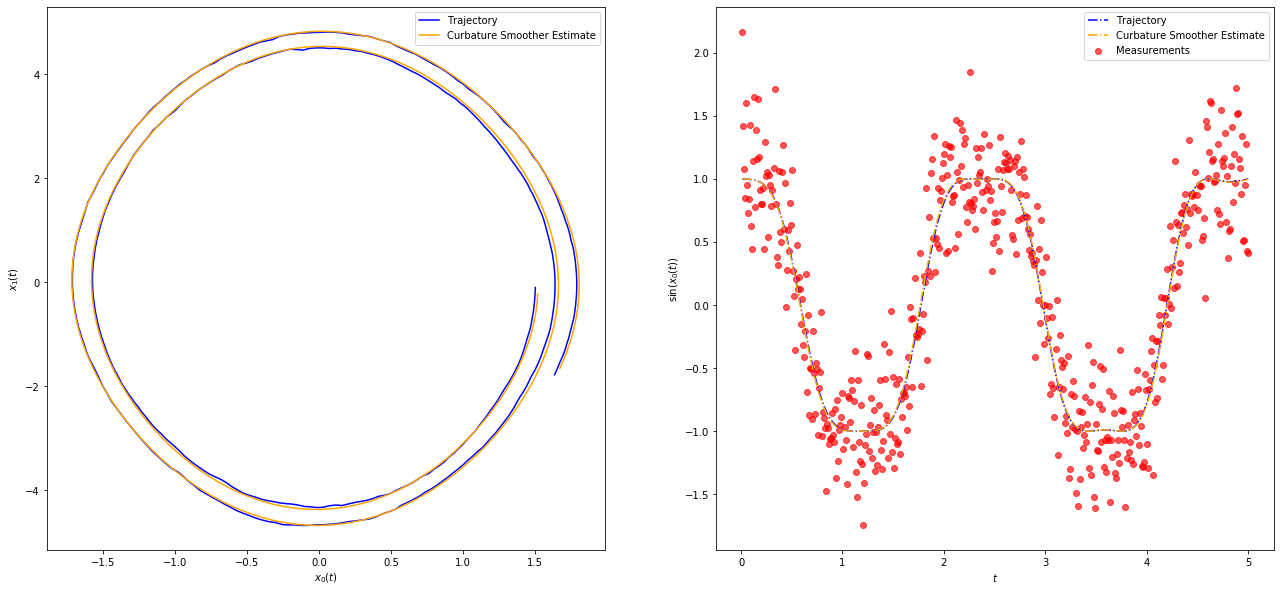

In [17]:
plot_pendulum(timeline, observations, states, "Trajectory", rts_m, "Curbature Smoother Estimate")

In [18]:
rmse_crts = rmse(rts_m[:, :1], states[:, :1])
print(f"CRTS RMSE: {rmse_crts}")

CRTS RMSE: 0.020240482756495544
